In [1]:
import pandas as pd #Mengolah data seperti excel
import tweepy #Diinstal dulu di anaconda prompt dengan run-> pip install tweepy
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize #Mengubah kata menjadi angka
import matplotlib.pyplot as pl
from sklearn.feature_extraction.text import CountVectorizer #Menghitung frekuensi kata yang muncul di suatu data
from sklearn.feature_extraction.text import TfidfTransformer #Pembobotan frekuensi masing-masing kata
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Training data digunakan data labeling twitter bahasa Indonesia yang dibuat oleh tim riset UGM http://ridi.staff.ugm.ac.id/2019/03/06/indonesia-sentiment-analysis-dataset/

In [3]:
ugm=pd.read_csv('Indonesian Sentiment Twitter Dataset Labeled.csv',delimiter='\t')
ugm

,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...
...,...,...
10801,1,Jangan membandingkan kehidupanmu dengan kehidu...
10802,0,Sini uname lu ntar gua follow
10803,1,Apapun yg telah kamu lakukan apapun kesalahanm...
10804,1,3 cara untuk ingat semula apa yang kita dah ha...


<AxesSubplot:>

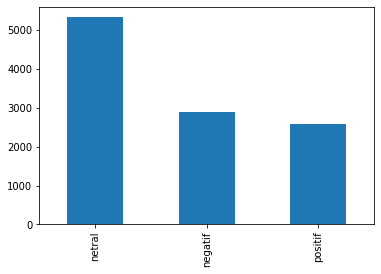

In [4]:
ugm.sentimen.replace({0:'netral',-1:'negatif',1:'positif'}).value_counts().plot(kind='bar')

In [5]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=nltk.corpus.stopwords.words('indonesian')) #Mengubah kata menjadi angka
X = vectorizer.fit_transform(ugm['Tweet']).toarray()
tfidfconverter = TfidfTransformer() #Pembobotan hasil vectonizer
X = tfidfconverter.fit_transform(X).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [6]:
y=ugm['sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Memisahkan data training dan test

In [7]:
model_svc = SVC(kernel='rbf')
model_svc.fit(X_train, y_train)

y_pred=model_svc.predict(X_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.40      0.47       560
           0       0.62      0.84      0.72      1101
           1       0.64      0.35      0.45       501

    accuracy                           0.62      2162
   macro avg       0.61      0.53      0.55      2162
weighted avg       0.61      0.62      0.59      2162

0.6151711378353376


## Pengaturan token Twitter API dan proses autentikasi

In [30]:
consumer_key='cEcWpJKUzM043X1RO2WFn6QJb'
consumer_secret='7OBpCTMblS1trVhXUH2vMG9oUtmuURnRIbIghKaL060EH8u5Ha'

access_token='61717767-I4auSvDEIdVt3KIdeOPS0QaaHigKt6i4b7wBHKX3y'
access_token_secret='DnwdboAFqOWemztgEOHrOEnvlhR3SImn3AKSkhhURE1KL'

auth=tweepy.OAuthHandler(consumer_key,consumer_secret) #Akses akun twitter
auth.set_access_token(access_token,access_token_secret) #Akses twitter general
api = tweepy.API(auth,wait_on_rate_limit=True) #Autentikasi twitter API

## Proses Scrapping

In [31]:
def scrappe(keyword,count,since,until): #Input: kata kunci, jumlah tweet yang diinginkan, tanggal awal, tanggal akhir
    text_query=f"since:{since} until:{until} {keyword}" #Query search twitter
    tweets = tweepy.Cursor(api.search,q=text_query).items(count) #Mencari tweet dengan kata kunci tertentu max seminggu sejak hari ini
    tweets_list = [[tweet.created_at, tweet.id, tweet.text, tweet.retweet_count, tweet.favorite_count,tweet.coordinates] for tweet in tweets] #Mengambil parameter yang diperlukan
    df_tweet=pd.DataFrame(tweets_list)
    df_tweet.columns=['tanggal','id','text','rt','fav','coor'] #tanggal: Tanggal tweet dipost, id: id tweet, text: isi tweet, rt: Jumlah retweet, fav: Jumlah favorit/like, coor: Koordinat lokasi
    return(df_tweet)

In [32]:
def proc_feature(features):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', features)
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()   
    return(processed_feature)

In [36]:
mudik=scrappe('Mudik',500,"2021-04-16","2021-04-24")

In [37]:
mudik

,tanggal,id,text,rt,fav,coor
0,2021-04-23 23:59:57,1385745289168887811,RT @na_dirs: Mudik dilarang. Tapi ke tempat wi...,2928,0,None
1,2021-04-23 23:59:37,1385745204863373313,RT @3L1z__4: WNA masuk yes\nPilkada Yes\nRekre...,2,0,None
2,2021-04-23 23:59:33,1385745189231239170,"RT @hipohan: Mudik gak boleh, tapi disuruh bel...",9,0,None
3,2021-04-23 23:59:31,1385745179458506754,RT @_AnakKolong: SEBAIKNYA SELURUH WARGA NEGAR...,115,0,None
4,2021-04-23 23:59:13,1385745104770506755,RT @DivHumas_Polri: Tak Ada Penjualan Tiket di...,14,0,None
...,...,...,...,...,...,...
4995,2021-04-23 16:49:02,1385636847422828548,"RT @ustadtengkuzul: Iya juga ya...\nPilkada, B...",688,0,None
4996,2021-04-23 16:49:00,1385636836190482440,"RT @PartaiSocmed: Dengan segala hormat, harap ...",77,0,None
4997,2021-04-23 16:48:56,1385636819954323459,RT @upinipinpath: WNA India masuk indonesia. K...,18,0,None
4998,2021-04-23 16:48:56,1385636818645766153,@_AnakKolong @KSPgoid @mohmahfudmd Bos sy setu...,0,0,None


In [38]:
X_pred=mudik['text'].apply(lambda x: proc_feature(x))
X_pred = vectorizer.transform(X_pred).toarray()
X_pred = tfidfconverter.transform(X_pred).toarray()

In [39]:
y_mudik_pred=model_svc.predict(X_pred)

In [40]:
mudik['label']=y_mudik_pred
mudik['Sentimen']=mudik['label'].replace({-1:'Negatif',0:'Netral',1:'Positif'})

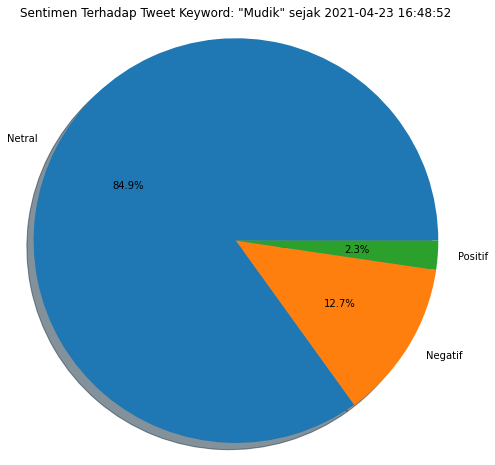

In [41]:
fig, ax = pl.subplots(figsize=[8,8])
ax.pie(mudik['Sentimen'].value_counts(),labels=mudik['Sentimen'].value_counts().index, autopct='%1.1f%%',
        shadow=True, radius=0.6)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(f'Sentimen Terhadap Tweet Keyword: "Mudik" sejak {mudik.tanggal.min()}')
pl.show()

## Engagement per Sentimen Berdasarkan Jumlah Retweet dan Like

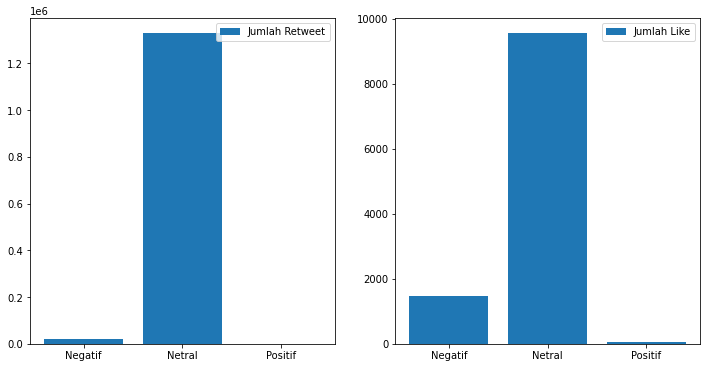

In [77]:
a=mudik.groupby('Sentimen').sum()
fig, ax = pl.subplots(ncols=2,nrows=1,figsize=[12,6])
ax[0].bar(x=a.index,height=a.rt,label='Jumlah Retweet')
ax[1].bar(x=a.index,height=a.fav,label='Jumlah Like')
ax[0].legend()
ax[1].legend()
pl.show()

<AxesSubplot:xlabel='Sentimen'>

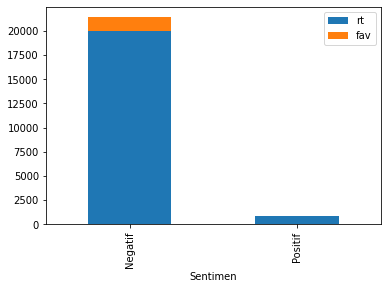

In [80]:
a[a.index!='Netral'][['rt','fav']].plot(kind='bar', stacked=True)

# Tweet Paling Banyak di-Retweet dan like

In [111]:
indeks=mudik[mudik['rt']==mudik['rt'].max()].index.values[0]
print(mudik['text'][indeks])
print('Jumlah retweet:',mudik['rt'][indeks])
print('Sentimen:',mudik['Sentimen'][indeks])

RT @FiersaBesari: Banyak paradoks di negeri ini. Mudik dilarang, tapi destinasi wisata buka serempak. Penutupan jalan raya, tapi malah mace…
Jumlah retweet: 62064
Sentimen: Netral


In [110]:
indeks=mudik[mudik['fav']==mudik['fav'].max()].index.values[0]
print(mudik['text'][indeks])
print('Jumlah Favorit/Like:',mudik['fav'][indeks])
print('Sentimen:',mudik['Sentimen'][indeks])

Mudik dilarang. Tapi ke tempat wisata, boleh. Santri juga boleh pulang. 

Kebijakan gak konsisten begini yg bikin s… https://t.co/8oAOuOEOKy
Jumlah Favorit/Like: 6328
Sentimen: Netral
